# Population decoding
Attempt at decoding behavioral data from population level neural activity.

This script uses .parquet files saved by analysis/ephys/population/save_data.py  
These are created by loading each recording's .h5 files, averaging data every 25ms and saving. 

In [15]:
import pandas as pd
from pathlib import Path
import sys
import statsmodels.api as sm
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
from fcutils.plot.figure import clean_axes
from sklearn.model_selection import KFold
from myterial import teal_dark,indigo_dark, blue_darker, pink, salmon_dark
from scipy.stats import pearsonr
import numpy as np

colors = dict(
    apex_distance=teal_dark,
    v=salmon_dark, 
    v_squared=salmon_dark, 
    dv_300ms=pink,
    omega=blue_darker,
    omega_squared=blue_darker,
    domega_300ms=indigo_dark,
)


sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from analysis.ephys.utils import get_recording_names

glm_cache = Path(
    r"D:\GLM\data"
)
population_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\data"
)

models_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\linreg_models"
)

parquet_files = list(
    population_cache.glob("*.parquet")
)


## Load data

In [16]:
def load_parquet_data(parquet_path):
    df = pd.read_parquet(population_cache / parquet_path)

    # keep only when v > 10
    df = df.loc[df.v > 10]

    # remove rows with nans
    df = df.dropna(axis=0)
    df.reset_index(inplace=True, drop=True)

    # normalize df
    df = (df - df.mean()) / (df.std() + 0.001)

    # get units_ids
    units = [c for c in df.columns[18:] if "shuffle" not in c]

    X = add_constant(df[units])
    X_shuffle = {
        i: add_constant(df[[f"{unit}_shuffle_{i}" for unit in units]]) for i in range(100)
    }


    return df, units, X, X_shuffle


# Linear regression

Using 5x kfold cross validation, fit OLS linear prediction to various behavioral variables from neural activity.
Fit models for real neural data and for each shuffles of real data.
Then look for which variables we can do better than the shuffles.

In [17]:
def fit_model(df:pd.DataFrame, X:pd.DataFrame, X_shuffle:dict, variable:str, savename:str):
    Y = df[variable]

    # split into 5x kfold
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)

    pearson_correlations = {f"{variable}_shuffle_{i}":[] for i in range(100)}
    pearson_correlations[variable] = []

    # loop over folds
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # fit OLS & getc correlation on test
        model = sm.OLS(Y_train, X_train).fit()
        model.save(str(models_cache / f"{savename}_{variable}_fold_{i}.pkl"))
        pearson_correlations[variable].append(
            pearsonr(model.predict(X_test), Y_test)[0]
        )


        # fit for each shuffle
        for s in range(100):
            X_train_shuffle = X_shuffle[s].iloc[train_index]
            X_test_shuffle = X_shuffle[s].iloc[test_index]

            # fit shuffled and get correlation
            model_shuffle = sm.OLS(Y_train, X_train_shuffle).fit()
            # model_shuffle.save(str(models_cache / f"{savename}_{variable}_shuffle_{s}_fold_{i}.pkl"))
            pearson_correlations[f"{variable}_shuffle_{s}"].append(
                pearsonr(model_shuffle.predict(X_test_shuffle), Y_test)[0]
            )


    return pearson_correlations


In [18]:
TARGET = "CUN/PPN"
recordings = get_recording_names(region=TARGET)
variables = ["v", "apex_distance",  "dv_300ms", "omega", "domega_300ms",]

# initialize empty data storage
correlations = {f"{variable}_shuffle_{i}":[] for i in range(100) for variable in variables}
for variable in variables:
    correlations[variable] = []
correlations["recording"] = []


for i, pqf in enumerate(parquet_files):
    if pqf.stem not in recordings:
        continue
    print(f"Doing recording {1+i}/{len(parquet_files)}")
    df, units, X, X_shuffle = load_parquet_data(pqf)
    if len(units) < 5:
        print(f"Skipping recording {pqf.stem} because it has less than 10 units")
        continue
    
    correlations["recording"].append(pqf.stem)

    for variable in variables:
        varcors = fit_model(df, X, X_shuffle,  variable, pqf.stem)

        for i in range(100):
            correlations[f"{variable}_shuffle_{i}"].append(
                np.mean(varcors[f"{variable}_shuffle_{i}"])
            )
        correlations[variable].append(np.mean(varcors[variable]))


Doing recording 1/54
Doing recording 3/54
Doing recording 5/54
Doing recording 7/54
Skipping recording FC_210722_AAA1110750_hairpin because it has less than 10 units
Doing recording 9/54
Doing recording 11/54
Doing recording 13/54
Doing recording 15/54
Skipping recording FC_210917_BAA1110279_hairpin because it has less than 10 units
Doing recording 17/54
Doing recording 19/54
Skipping recording FC_211027_BAA110516_hairpin because it has less than 10 units
Doing recording 21/54
Skipping recording FC_211214_BAA110517_hairpin because it has less than 10 units
Doing recording 23/54
Skipping recording FC_220114_BAA110517_hairpin because it has less than 10 units
Doing recording 25/54
Doing recording 27/54
Doing recording 29/54


In [19]:
# Save avg correlation of each model
pd.DataFrame(correlations).to_hdf(
    str(population_cache.parent / "linmods_correlations.h5"), key="hdf",
)

# Analysis

Get for each variables which models performed better than chance.

In [20]:
correlations = pd.DataFrame(correlations)
cols = [c for c in correlations.columns if "shuffle" not in c and "recording" not in c]
cols

['v', 'apex_distance', 'dv_300ms', 'omega', 'domega_300ms']

In [21]:
import matplotlib
import matplotlib.patheffects as path_effects
from matplotlib.artist import Artist

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


def outline(artist: Artist, lw: float = 1, color: str = "white"):
    artist.set_path_effects(
        [path_effects.withStroke(linewidth=lw, foreground=color,)]
    )


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 1728x864 with 5 Axes>

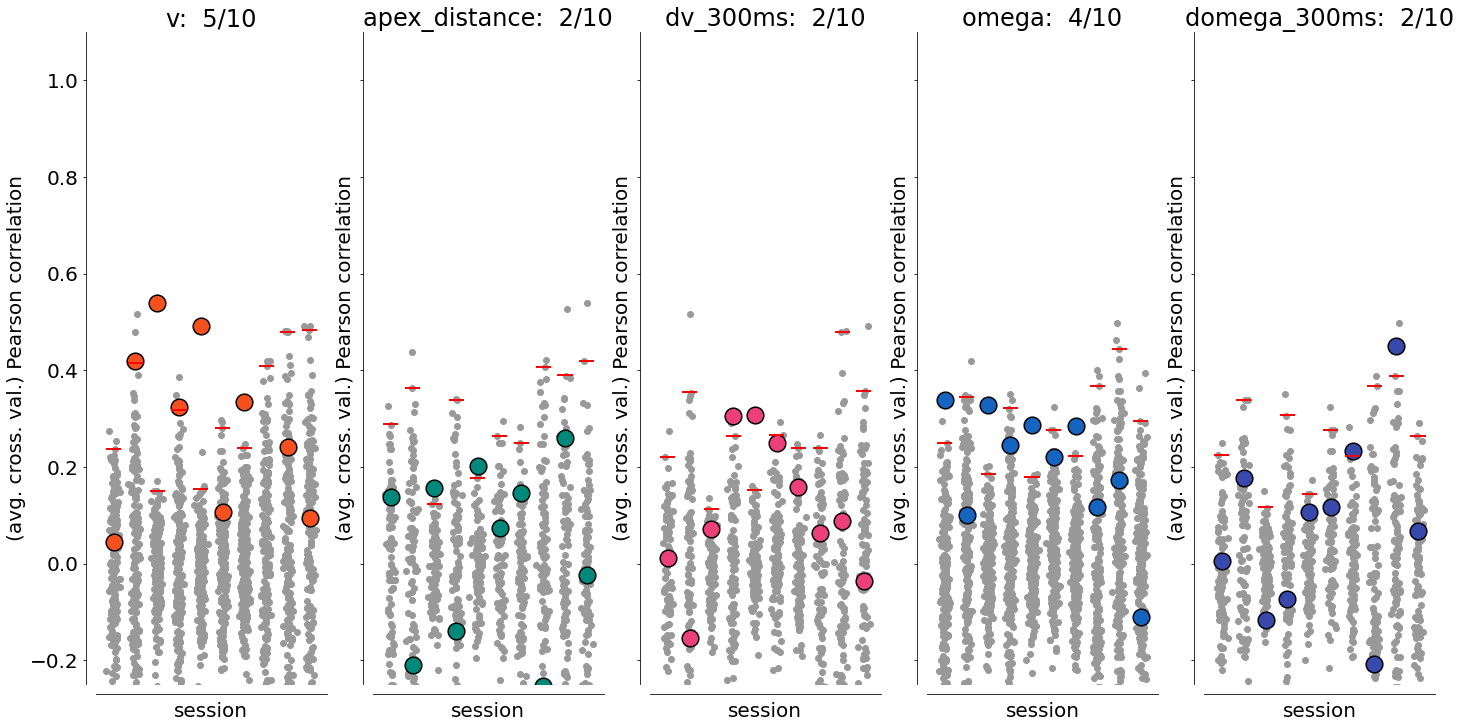

In [22]:
recs = [f.stem for f in parquet_files]


ONE = np.ones(len(correlations))

f, axes = plt.subplots(1, len(variables), figsize=(24, 12), sharey=True, sharex=True)

for n, var in enumerate(cols):
    ax = axes[n]
    shuffle_cols = [c for c in correlations.columns if "shuffle" in c and var in c]


    # count recordings above noise threshold and plot (iterating over recordings)
    count = 0
    for i in range(correlations[var].shape[0]):
        # plot correlation values
        y = correlations[var].iloc[i]
        # x = ONE * n + np.random.normal(0, .07, len(correlations))
        x = i
        ax.scatter(x, y, color="k", s=200, lw=4, ec="k", zorder=100, label=var)
        ax.scatter(x, y, color=colors[var], s=200, zorder=100, label=var)


        # plot shuffled correlations
        y_shuff = correlations[shuffle_cols].iloc[i].values.ravel()

        x = np.ones(len(y_shuff)) * x + np.random.normal(0, .1, len(y_shuff))
        ax.scatter(x, y_shuff, color=[.6, .6, .6], alpha=1, zorder=-1)


        # get > threshold
        th = np.nanpercentile(y_shuff, 99)
        ax.plot([i-.3, i+.3], [th, th], color="r", lw=2, zorder=100)

        if y > th:
            count += 1

    # add text to display count
    # ax.text(n*12-.2, 1, f"{count}/{len(correlations[var])}", color=[.4, .4, .4], fontsize=20, fontweight="bold")
    _ = ax.set(ylim=[-.25, 1.1],  ylabel="(avg. cross. val.) Pearson correlation", title=f"{var}:  {count}/{len(correlations[var])}", xlabel="session", xticks=[])

clean_axes(f)
# _ = ax.set(ylim=[-.25, 1.1],  xticks=np.arange(len(cols)), xticklabels=cols, ylabel="(avg. cross. val.) Pearson correlation")
# save figure
TARGET = TARGET if "MOs" in TARGET else "CUN_PPN"
f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\population_decoding_{TARGET}.svg")

### plot predictions for a recording

In [23]:
# plot histogram of average MSE for each shuffle


def plot_results(rec_data, units_data, models_correlations, fitted_models, t0=2000, dt=1000):
    f, axes = plt.subplots(ncols=2, nrows=len(variables), figsize=(20, 18), gridspec_kw={"width_ratios": [.33, 1]}, sharex=False)

    t0 = int(t0/25)  # to fix for data sampling rate
    dt = int(dt/25)


    for i, var in enumerate(variables):
        # plot pearsonr distributions
        K = list(models_correlations[f"{var}_shuffle_{0}"].keys())[0]
        avg_shuff_pearsonr = [models_correlations[f"{var}_shuffle_{i}"][K] for i in range(100)]

        low, high = np.percentile(avg_shuff_pearsonr, [.5, 99.5])
        axes[i, 0].plot([low, high], [-1, -1], color="k", linewidth=2)
        axes[i, 0].scatter([np.median(avg_shuff_pearsonr)], [-1], color="white",fc="white", zorder=100, ec="k", linewidth=1, s=25)

        axes[i, 0].hist(avg_shuff_pearsonr, color=[.5, .5, .5])
        axes[i, 0].axvline(models_correlations[var][K], color=colors[var], lw=4)
        
        axes[i, 0].set(title=var, xlim=[-.25, 1])
        axes[i, 0].axvline(0, lw=2, color="k", zorder=100)

        # plot predictions of real and shuffled models
        # axes[i, 1].fill_between(rec_data[var][0:1000].values, 0, color="k", alpha=.25, label="data")
        axes[i, 1].plot(rec_data[var][t0 : t0+dt].values, color="k", lw=4, alpha=.25)
        axes[i, 1].plot(fitted_models[f"{var}_fold_1"].predict(units_data[t0:t0+dt]).values, color=colors[var], lw=4, label="prediction")


    axes[0, 0].set(ylabel="count", xticks=[-1, 1], xlabel="Pearson correlation")
    axes[1, 0].set(ylabel="count", xticks=[-1, 1], xlabel="Pearson correlation")
    axes[2, 0].set(ylabel="count", xticks=[-1, 1], xlabel="Pearson correlation")
    axes[3, 0].set(ylabel="count", xticks=[-1, 1], xlabel="Pearson correlation")
    axes[4, 0].set(ylabel="count", xticks=[-1, 1], xlabel="Pearson correlation")

    axes[0, 1].set(ylabel="speed (cm.s)", xticks=[])
    axes[1, 1].set(ylabel="apex distance (cm)", xticks=[])
    axes[2, 1].set(ylabel="delta speed (cm/s)", xticks=[])
    axes[3, 1].set(ylabel="ang. vel. (deg/s)", xticks=[])
    axes[4, 1].set(ylabel="delta ang. vel. (deg/s)", xlabel="time (ms)", xticks=[0, dt], xticklabels=[0, dt*25])

    clean_axes(f)
    f.tight_layout()
    return f


# plot_results(X, RESULTS, MODELS, t0=2000)

In [24]:

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 14}

# matplotlib.rc('font', **font)


# rec = recordings[7]  # best is 7

# rec_models = {f.stem.replace(rec, "")[1:]: sm.load(f) for f in models_cache.glob(f"{rec}*.pkl")}
# rec_correlations = correlations.loc[correlations.recording == rec].to_dict()
# df, units, X, X_shuffle = load_parquet_data(rec+".parquet")


# f  = plot_results(df, X, rec_correlations, rec_models, t0=55_000, dt=10000)
# f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\population_decoding_{TARGET}_prediction.svg")

# Analyze correlation between variables

In [25]:
tracking = {v:[] for v in variables}

for i, pqf in enumerate(parquet_files):
    print(f"Doing recording {1+i}/{len(parquet_files)}")
    df, units, X, X_shuffle = load_parquet_data(pqf)

    for var in variables:
        tracking[var].extend(df[var].values)

Doing recording 1/54
Doing recording 2/54
Doing recording 3/54
Doing recording 4/54
Doing recording 5/54
Doing recording 6/54
Doing recording 7/54
Doing recording 8/54
Doing recording 9/54
Doing recording 10/54
Doing recording 11/54
Doing recording 12/54
Doing recording 13/54
Doing recording 14/54
Doing recording 15/54
Doing recording 16/54
Doing recording 17/54
Doing recording 18/54
Doing recording 19/54
Doing recording 20/54
Doing recording 21/54
Doing recording 22/54
Doing recording 23/54
Doing recording 24/54
Doing recording 25/54
Doing recording 26/54
Doing recording 27/54
Doing recording 28/54
Doing recording 29/54
Doing recording 30/54
Doing recording 31/54
Doing recording 32/54
Doing recording 33/54
Doing recording 34/54
Doing recording 35/54
Doing recording 36/54
Doing recording 37/54
Doing recording 38/54
Doing recording 39/54
Doing recording 40/54
Doing recording 41/54
Doing recording 42/54
Doing recording 43/54
Doing recording 44/54
Doing recording 45/54
Doing recording 46/

<Figure size 1440x1440 with 25 Axes>

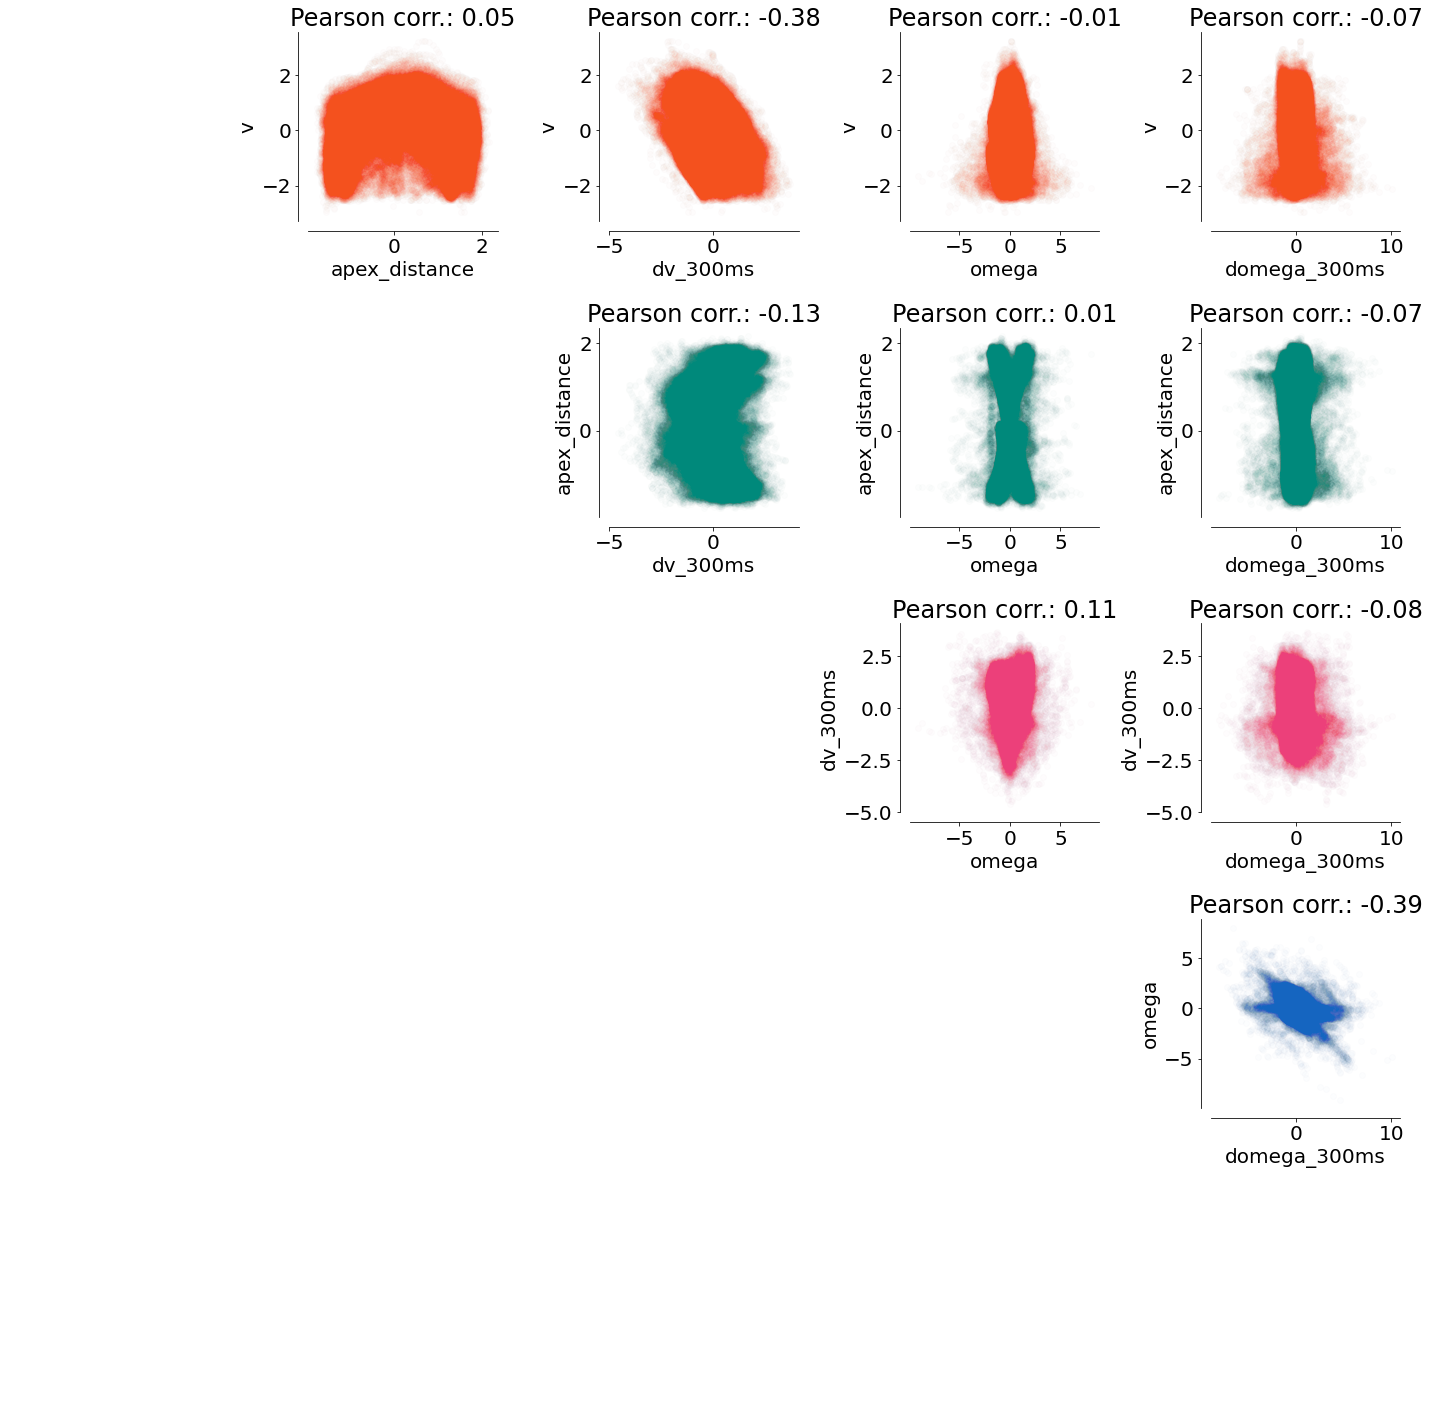

In [26]:

f, axes = plt.subplots(len(variables), len(variables), figsize=(20, 20))

for i, var in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i >= j:
            axes[i, j].axis("off")
            continue

        # scatter plot of var vs var2 and linear regression between the two
        axes[i, j].scatter(tracking[var2], tracking[var],  alpha=.01, color=colors[var])

      
        # compute pearson correlation between var and var2
        pearsonr = np.corrcoef(tracking[var], tracking[var2])[0, 1]
        axes[i, j].set(xlabel=var2, ylabel=var , title=f"Pearson corr.: {pearsonr:.2f}")
        
clean_axes(f)
f.tight_layout()
f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\population_decoding_{TARGET}_behav_vars_corr.svg")

compute/plot pearson correlation matrix

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)
    return cbar

<Figure size 720x720 with 2 Axes>

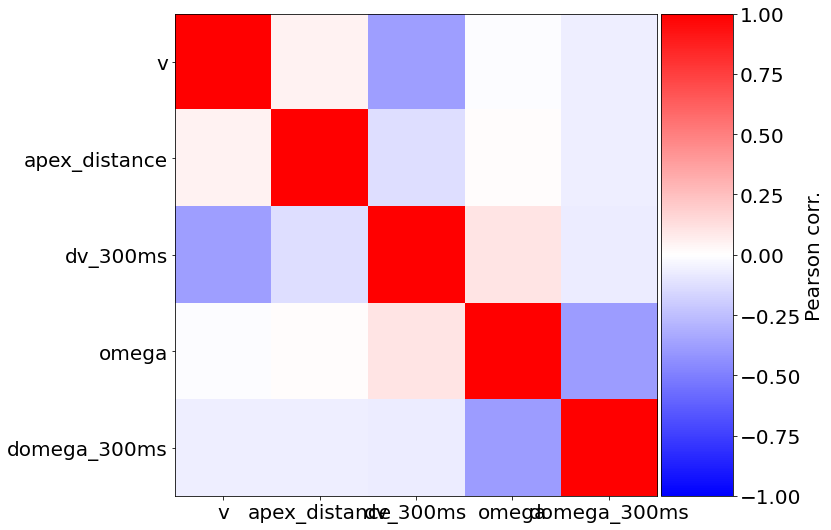

In [28]:
corr = np.zeros((len(variables), len(variables)))

for i, var in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i > j:
            continue

        pearsonr = np.corrcoef(tracking[var], tracking[var2])[0, 1]
        corr[i, j] = pearsonr
        corr[j, i] = pearsonr


# plot the correlation matrix with the variables as ticks
f, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr, cmap="bwr", vmin=-1, vmax=1)

add_colorbar(ax, im, "Pearson corr.")

_ = ax.set(xticks=np.arange(len(variables)), yticks=np.arange(len(variables)), xticklabels=variables, yticklabels=variables)
f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\population_decoding_{TARGET}_behav_vars_corr_heatmap.svg")